# imports

In [1]:
import gc

import sklearn.linear_model as sk
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix, matthews_corrcoef
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.tree import export_graphviz
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Input, Dense, Dropout, Lambda, Concatenate
from tensorflow.keras.models import Model
from keras.layers import Input
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import plot_model
import tensorflow.keras.backend as K
import math

from tensorflow.keras.layers import Input, Dense, Dropout, LeakyReLU, Concatenate, Multiply, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

import numpy as np
from numpy import mean
from numpy import std


from six import StringIO
from IPython.display import Image
# import pydotplus

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm

import seaborn as sns
import pandas as pd
import random
from math import log
from keras.models import load_model
import sys
import csv
from urllib.request import urlretrieve
import pickle as pickle
import os
import gzip
from collections.abc import MutableMapping
from tqdm import tqdm
from zipfile import ZipFile

# all 5 folds

## train all

In [34]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import pickle
import os

# Define Swish activation function
def swish(x):
    return x * tf.nn.sigmoid(x)

tf.random.set_seed(42)

# Load HLA features (drop non-feature columns)
hla_df = pd.read_csv(r"C:\Users\asus\Desktop\final_entropy_column.csv")
hla_df = hla_df.drop(columns=["Unnamed: 0"])  # Correct way to drop a column
hla_df = hla_df.set_index("HLA")  # Set HLA column as index

# Load peptide embeddings
with open(r"C:\Users\asus\Desktop\revised things\train_ESM320_embeddings.pkl", "rb") as f:
    peptide_embeddings = pickle.load(f)

# Load all folds
folds = [
    pd.read_csv(rf"C:\Users\asus\Desktop\revised things\TransPHLA-AOMP-master\TransPHLA-AOMP-master\Dataset\train_data_fold{i}.csv")
    for i in range(5)
]
# Remove '*' from HLA names
for fold in folds:
    fold["HLA"] = fold["HLA"].str.replace("*", "", regex=False)
# Assume df1, df2, df3, df4, df5 are your data frames
# merged_df = pd.concat([folds[0], folds[1], folds[2], folds[3], folds[4]], axis=0)  # axis=0 for row-wise
merged_df = folds[0]  # axis=0 for row-wise

In [74]:
# Model input shapes
input_shape1 = (320,)  # Peptide
input_shape2 = (180,)  # HLA

# Define model
left_input = Input(shape=input_shape1)
right_input = Input(shape=input_shape2)

encoded_l = Dense(256, activation=swish)(left_input)
encoded_l = Dropout(0.2)(encoded_l)
encoded_l = Dense(128, activation=swish)(encoded_l)
encoded_l = Dropout(0.2)(encoded_l)

encoded_r = Dense(128, activation=swish)(right_input)
encoded_r = Dropout(0.5)(encoded_r)

L1_layer = Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))
L1_distance = L1_layer([encoded_l, encoded_r])

concatenated = Dense(64, activation=swish)(L1_distance)
concatenated = Dropout(0.2)(concatenated)
concatenated = Dense(32, activation=swish)(concatenated)

prediction = Dense(1, activation="sigmoid")(concatenated)

siamese_net = Model(inputs=[left_input, right_input], outputs=prediction)

optimizer = Adam(learning_rate=0.0001)
siamese_net.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy", "AUC", "Precision", "Recall"])

In [75]:
# Training Parameters
batch_size = 512  # Fixed batch size
initial_lr = 0.001  # Fixed learning rate
epochs = 10  # Total epochs

# Assume `fold` is your single fold of data
# print("Training on the single fold...")

# Prepare the data
peptides = np.array([peptide_embeddings[p] for p in merged_df["peptide"]])
hlas = np.array([hla_df.loc[h].values for h in merged_df["HLA"]])
labels = merged_df["label"].values

# Training Loop
# for epoch in range(epochs):
#     print(f"Epoch {epoch + 1}/{epochs}")

#     # Train the model for one epoch
#     history = siamese_net.fit(
#         [peptides, hlas], labels,
#         batch_size=batch_size,
#         epochs=1,  # Train for one epoch at a time
#         verbose=1
#     )

In [77]:
early_stopping = EarlyStopping(
    monitor="loss",  # Monitor training loss
    patience=10,  # Number of epochs with no improvement before stopping
    restore_best_weights=True,  # Restore model to best epoch
    min_delta=0.0001,  # Minimum change to qualify as an improvement
)

history = siamese_net.fit(
        [peptides, hlas], labels,
        batch_size=batch_size,
        epochs=50,  
        verbose=1,
        callbacks=[early_stopping]
    )

print("Training Complete!")

Epoch 1/50
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 25s 22ms/step - AUC: 0.9392 - Precision: 0.8599 - Recall: 0.8764 - accuracy: 0.8665 - loss: 0.3148
Epoch 2/50
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - AUC: 0.9395 - Precision: 0.8606 - Recall: 0.8774 - accuracy: 0.8674 - loss: 0.3139
Epoch 3/50
 243/1123 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - AUC: 0.9394 - Precision: 0.8615 - Recall: 0.8785 - accuracy: 0.8682 - loss: 0.3143

KeyboardInterrupt: 

In [17]:
# Save the trained model
siamese_net.save(r"C:\Users\asus\Desktop\siamese_all_5_fold_new_feature.h5")

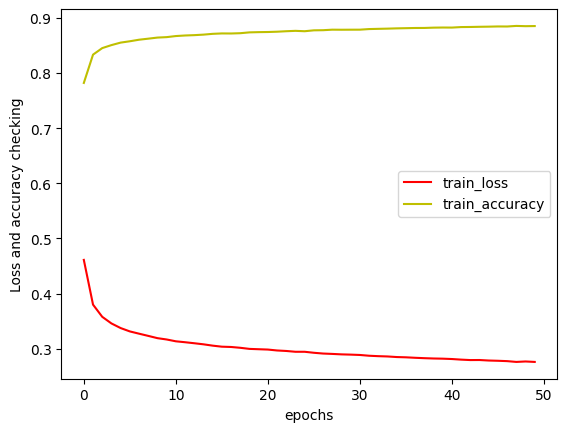

In [38]:
# Plotting training loss and accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], 'r', label='train_loss')
plt.plot(history.history['accuracy'], 'y', label='train_accuracy')
plt.xlabel('epochs')
plt.ylabel('Loss and accuracy checking')
plt.legend()
plt.show()

## train separately

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import pickle
import os

# Define Swish activation function
def swish(x):
    return x * tf.nn.sigmoid(x)

tf.random.set_seed(42)

# Load HLA features (drop non-feature columns)
hla_df = pd.read_csv(r"C:\Users\asus\Desktop\master article\Maryam\esm320\final_entropy.csv")
hla_df = hla_df.drop(columns=["Unnamed: 0"])  # Correct way to drop a column
hla_df = hla_df.set_index("HLA")  # Set HLA column as index

# Load peptide embeddings
with open(r"C:\Users\asus\Desktop\revised things\train_ESM320_embeddings.pkl", "rb") as f:
    peptide_embeddings = pickle.load(f)

# Load all folds
folds = [
    pd.read_csv(rf"C:\Users\asus\Desktop\revised things\TransPHLA-AOMP-master\TransPHLA-AOMP-master\Dataset\train_data_fold{i}.csv")
    for i in range(5)
]
# Remove '*' from HLA names
for fold in folds:
    fold["HLA"] = fold["HLA"].str.replace("*", "", regex=False)

In [ ]:
# Model input shapes
input_shape1 = (320,)  # Peptide
input_shape2 = (180,)  # HLA

# Define model
left_input = Input(shape=input_shape1)
right_input = Input(shape=input_shape2)

encoded_l = Dense(256, activation=swish)(left_input)
encoded_l = Dropout(0.2)(encoded_l)
encoded_l = Dense(128, activation=swish)(encoded_l)
encoded_l = Dropout(0.2)(encoded_l)

encoded_r = Dense(128, activation=swish)(right_input)
encoded_r = Dropout(0.2)(encoded_r)

L1_layer = Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))
L1_distance = L1_layer([encoded_l, encoded_r])

concatenated = Dense(64, activation=swish)(L1_distance)
concatenated = Dropout(0.2)(concatenated)
concatenated = Dense(32, activation=swish)(concatenated)

prediction = Dense(1, activation="sigmoid")(concatenated)

siamese_net = Model(inputs=[left_input, right_input], outputs=prediction)

optimizer = Adam(learning_rate=0.001)
siamese_net.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy", "AUC", "Precision", "Recall"])

In [4]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import CosineDecay
import numpy as np

# Define early stopping based on training loss
early_stopping = EarlyStopping(
    monitor="loss",  # Monitor training loss
    patience=10,  # Number of epochs with no improvement before stopping
    restore_best_weights=True,  # Restore model to best epoch
    min_delta=0.0001,  # Minimum change to qualify as an improvement
)

# Function to compute the current batch size based on the warmup schedule
def get_current_batch_size(epoch, initial_batch_size, final_batch_size, warmup_epochs):
    if epoch < warmup_epochs:
        # Linear warmup
        return initial_batch_size + (final_batch_size - initial_batch_size) * (epoch / warmup_epochs)
    else:
        return final_batch_size

# Function to compute the current learning rate based on the batch size
def get_current_learning_rate(initial_lr, current_batch_size, initial_batch_size):
    return initial_lr * (current_batch_size / initial_batch_size)

# Training with Transfer Learning
initial_batch_size = 64  # Start with a smaller batch size
final_batch_size = 512  # Target batch size
warmup_epochs = 10  # Number of epochs for warmup
initial_lr = 0.001  # Initial learning rate

# Define a learning rate scheduler after warmup
lr_schedule = CosineDecay(
    initial_learning_rate=initial_lr * (final_batch_size / initial_batch_size),
    decay_steps=120 - warmup_epochs
)

for i, fold in enumerate(folds):
    print(f"\nTraining on Fold {i+1}/5...\n")
    
    # Match peptides & HLAs
    peptides = np.array([peptide_embeddings[p] for p in fold["peptide"]])
    hlas = np.array([hla_df.loc[h].values for h in fold["HLA"]])
    labels = fold["label"].values

    # Custom training loop with batch size warmup, learning rate adjustment, and early stopping
    for epoch in range(120):  # Total epochs
        # Compute the current batch size
        current_batch_size = int(get_current_batch_size(epoch, initial_batch_size, final_batch_size, warmup_epochs))
        
        # Compute the current learning rate
        if epoch < warmup_epochs:
            # During warmup, scale the learning rate linearly with the batch size
            current_lr = get_current_learning_rate(initial_lr, current_batch_size, initial_batch_size)
        else:
            # After warmup, use the learning rate scheduler
            current_lr = lr_schedule(epoch - warmup_epochs)
        
        # Update the learning rate in the optimizer
        siamese_net.optimizer.learning_rate.assign(current_lr)
        
        # Train the model for one epoch with the current batch size
        history = siamese_net.fit(
            [peptides, hlas], labels,
            epochs=1,  # Train for one epoch at a time
            batch_size=current_batch_size,
            verbose=1,
            callbacks=[early_stopping]  # Add early stopping callback
        )
        
        # Check if early stopping was triggered
        if early_stopping.stopped_epoch > 0:
            print(f"Early stopping triggered at epoch {epoch + 1}.")
            break

print("Training Complete!")


Training on Fold 1/5...

8980/8980 ━━━━━━━━━━━━━━━━━━━━ 88s 9ms/step - AUC: 0.8272 - Precision: 0.7345 - Recall: 0.7914 - accuracy: 0.7518 - loss: 0.5020
5321/5321 ━━━━━━━━━━━━━━━━━━━━ 57s 11ms/step - AUC: 0.9044 - Precision: 0.8138 - Recall: 0.8502 - accuracy: 0.8275 - loss: 0.3899
3756/3756 ━━━━━━━━━━━━━━━━━━━━ 46s 12ms/step - AUC: 0.9145 - Precision: 0.8266 - Recall: 0.8585 - accuracy: 0.8389 - loss: 0.3699
2903/2903 ━━━━━━━━━━━━━━━━━━━━ 40s 14ms/step - AUC: 0.9198 - Precision: 0.8322 - Recall: 0.8622 - accuracy: 0.8439 - loss: 0.3591
2365/2365 ━━━━━━━━━━━━━━━━━━━━ 36s 15ms/step - AUC: 0.9235 - Precision: 0.8374 - Recall: 0.8663 - accuracy: 0.8488 - loss: 0.3513
1996/1996 ━━━━━━━━━━━━━━━━━━━━ 33s 16ms/step - AUC: 0.9263 - Precision: 0.8411 - Recall: 0.8690 - accuracy: 0.8522 - loss: 0.3452
1731/1731 ━━━━━━━━━━━━━━━━━━━━ 31s 18ms/step - AUC: 0.9280 - Precision: 0.8431 - Recall: 0.8714 - accuracy: 0.8544 - loss: 0.3410
1525/1525 ━━━━━━━━━━━━━━━━━━━━ 29s 19ms/step - AUC: 0.9302 - Prec

## 5 fold

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import pickle
import os

# Define Swish activation function
def swish(x):
    return x * tf.nn.sigmoid(x)

tf.random.set_seed(42)

# Load HLA features (drop non-feature columns)
hla_df = pd.read_csv(r"C:\Users\asus\Desktop\master article\Maryam\esm320\final_entropy.csv")
hla_df = hla_df.drop(columns=["Unnamed: 0"])  # Correct way to drop a column
hla_df = hla_df.set_index("HLA")  # Set HLA column as index

# Load peptide embeddings
with open(r"C:\Users\asus\Desktop\revised things\train_ESM320_embeddings.pkl", "rb") as f:
    peptide_embeddings = pickle.load(f)

# Load all folds
folds = [
    pd.read_csv(rf"C:\Users\asus\Desktop\revised things\TransPHLA-AOMP-master\TransPHLA-AOMP-master\Dataset\train_data_fold{i}.csv")
    for i in range(5)
]
# Remove '*' from HLA names
for fold in folds:
    fold["HLA"] = fold["HLA"].str.replace("*", "", regex=False)

In [2]:
# Model input shapes
input_shape1 = (320,)  # Peptide
input_shape2 = (180,)  # HLA

# Define model
left_input = Input(shape=input_shape1)
right_input = Input(shape=input_shape2)

encoded_l = Dense(256, activation=swish)(left_input)
encoded_l = Dropout(0.2)(encoded_l)
encoded_l = Dense(128, activation=swish)(encoded_l)
encoded_l = Dropout(0.2)(encoded_l)

encoded_r = Dense(128, activation=swish)(right_input)
encoded_r = Dropout(0.2)(encoded_r)

L1_layer = Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))
L1_distance = L1_layer([encoded_l, encoded_r])

concatenated = Dense(64, activation=swish)(L1_distance)
concatenated = Dropout(0.2)(concatenated)
concatenated = Dense(32, activation=swish)(concatenated)

prediction = Dense(1, activation="sigmoid")(concatenated)

siamese_net = Model(inputs=[left_input, right_input], outputs=prediction)

optimizer = Adam(learning_rate=0.001)
siamese_net.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy", "AUC", "Precision", "Recall"])

In [ ]:
import numpy as np
from sklearn.metrics import (roc_auc_score, average_precision_score, 
                            matthews_corrcoef, accuracy_score, 
                            confusion_matrix, classification_report)
from tensorflow.keras.optimizers import Adam

# Configuration
batch_size = 512
learning_rate = 0.001
epochs = 100

# Initialize metric storage
metrics = {
    'AUC': [],
    'AUPR': [],
    'MCC': [],
    'ACC': [],
    'Specificity': [],
    'Sensitivity': []
}

for test_fold_idx in range(5):
    print(f"\n\n{'='*50}")
    print(f"=== Training on 4 folds, Testing on Fold {test_fold_idx + 1} ===")
    print(f"{'='*50}\n")
    
    # Combine 4 folds for training
    train_peptides = []
    train_hlas = []
    train_labels = []
    
    for fold_idx in range(5):
        if fold_idx != test_fold_idx:
            fold = folds[fold_idx]
            train_peptides.extend(fold['peptide'])
            train_hlas.extend(fold['HLA'])
            train_labels.extend(fold['label'])
    
    # Use current fold for testing
    test_fold = folds[test_fold_idx]
    test_peptides = test_fold['peptide']
    test_hlas = test_fold['HLA']
    test_labels = test_fold['label']
    
    # Convert to embeddings
    X_train_pep = np.array([peptide_embeddings[p] for p in train_peptides])
    X_train_hla = np.array([hla_df.loc[h].values for h in train_hlas])
    y_train = np.array(train_labels)
    
    X_test_pep = np.array([peptide_embeddings[p] for p in test_peptides])
    X_test_hla = np.array([hla_df.loc[h].values for h in test_hlas])
    y_test = np.array(test_labels)
    
    # Recompile model for fresh training
    siamese_net.compile(
        optimizer=Adam(learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    # Train
    print(f"Training samples: {len(X_train_pep)}, Test samples: {len(X_test_pep)}")
    siamese_net.fit(
        [X_train_pep, X_train_hla], y_train,
        epochs=epochs,
        batch_size=batch_size,
        verbose=1
    )
    
    # Predict probabilities and classes
    y_pred_probs = siamese_net.predict([X_test_pep, X_test_hla]).flatten()
    y_pred_classes = (y_pred_probs > 0.5).astype(int)
    
    # Calculate all metrics
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_classes).ravel()
    
    metrics['AUC'].append(roc_auc_score(y_test, y_pred_probs))
    metrics['AUPR'].append(average_precision_score(y_test, y_pred_probs))
    metrics['MCC'].append(matthews_corrcoef(y_test, y_pred_classes))
    metrics['ACC'].append(accuracy_score(y_test, y_pred_classes))
    metrics['Specificity'].append(tn / (tn + fp))
    metrics['Sensitivity'].append(tp / (tp + fn))
    
    # Print fold results
    print(f"\n{'='*30}")
    print(f"Fold {test_fold_idx + 1} Detailed Results:")
    print(f"{'='*30}")
    
    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_classes, digits=4))
    
    # Confusion Matrix
    print("\nConfusion Matrix:")
    print(f"True Negatives: {tn}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"True Positives: {tp}")
    
    # Additional Metrics
    print("\nAdditional Metrics:")
    print(f"AUC: {metrics['AUC'][-1]:.4f}")
    print(f"AUPR: {metrics['AUPR'][-1]:.4f}")
    print(f"MCC: {metrics['MCC'][-1]:.4f}")
    print(f"Accuracy: {metrics['ACC'][-1]:.4f}")
    print(f"Specificity: {metrics['Specificity'][-1]:.4f}")
    print(f"Sensitivity: {metrics['Sensitivity'][-1]:.4f}")

# Calculate and display final results
print("\n\n" + "="*50)
print("=== Final 5-Fold Cross-Validation Results ===")
print("="*50)

print("\nIndividual Fold Results:")
print("Fold\tAUC\tAUPR\tMCC\tACC\tSpec\tSens")
for i in range(5):
    print(f"{i+1}\t" + "\t".join(f"{metrics[metric][i]:.4f}" 
          for metric in ['AUC', 'AUPR', 'MCC', 'ACC', 'Specificity', 'Sensitivity']))

print("\nAverage Metrics:")
print("Metric\tMean\tStd")
for metric in metrics:
    print(f"{metric}\t{np.mean(metrics[metric]):.4f}\t{np.std(metrics[metric]):.4f}")

# Save all results to a dictionary for further analysis
results = {
    'per_fold_metrics': metrics,
    'average_metrics': {metric: np.mean(values) for metric, values in metrics.items()},
    'std_metrics': {metric: np.std(values) for metric, values in metrics.items()}
}



=== Training on 4 folds, Testing on Fold 1 ===

Training samples: 2298670, Test samples: 574658
Epoch 1/100
4490/4490 ━━━━━━━━━━━━━━━━━━━━ 83s 17ms/step - accuracy: 0.7881 - loss: 0.4467
Epoch 2/100
4490/4490 ━━━━━━━━━━━━━━━━━━━━ 77s 17ms/step - accuracy: 0.8565 - loss: 0.3358
Epoch 3/100
4490/4490 ━━━━━━━━━━━━━━━━━━━━ 77s 17ms/step - accuracy: 0.8646 - loss: 0.3190
Epoch 4/100
4490/4490 ━━━━━━━━━━━━━━━━━━━━ 53s 12ms/step - accuracy: 0.8693 - loss: 0.3097
Epoch 5/100
4490/4490 ━━━━━━━━━━━━━━━━━━━━ 43s 10ms/step - accuracy: 0.8720 - loss: 0.3033
Epoch 6/100
4490/4490 ━━━━━━━━━━━━━━━━━━━━ 43s 10ms/step - accuracy: 0.8742 - loss: 0.2988
Epoch 7/100
4490/4490 ━━━━━━━━━━━━━━━━━━━━ 48s 11ms/step - accuracy: 0.8762 - loss: 0.2952
Epoch 8/100
4490/4490 ━━━━━━━━━━━━━━━━━━━━ 48s 11ms/step - accuracy: 0.8781 - loss: 0.2911
Epoch 9/100
4490/4490 ━━━━━━━━━━━━━━━━━━━━ 48s 11ms/step - accuracy: 0.8794 - loss: 0.2882
Epoch 10/100
4490/4490 ━━━━━━━━━━━━━━━━━━━━ 49s 11ms/step - accuracy: 0.8807 - loss

In [16]:
results['average_metrics']

{'AUC': np.float64(0.9783921078641467),
 'AUPR': np.float64(0.976240480221686),
 'MCC': np.float64(0.8482882228162769),
 'ACC': np.float64(0.9231287140918056),
 'Specificity': np.float64(0.8895096629564143),
 'Sensitivity': np.float64(0.9567477652271968)}

In [23]:
results['std_metrics']

{'AUC': np.float64(0.002975898493658373),
 'AUPR': np.float64(0.002993959373452749),
 'MCC': np.float64(0.014694229296108894),
 'ACC': np.float64(0.007777530130314855),
 'Specificity': np.float64(0.016215746754368557),
 'Sensitivity': np.float64(0.0025139005343834237)}

In [17]:
results['per_fold_metrics']['AUC']

[np.float64(0.9733621979103274),
 np.float64(0.9772357251790202),
 np.float64(0.978969645184864),
 np.float64(0.9803076585721329),
 np.float64(0.9820853124743887)]

In [18]:
results['per_fold_metrics']['AUPR']

[np.float64(0.9712104499011122),
 np.float64(0.9750325365966928),
 np.float64(0.9767818614539365),
 np.float64(0.9782112935548505),
 np.float64(0.9799662596018375)]

In [19]:
results['per_fold_metrics']['MCC']

[np.float64(0.8259118477991703),
 np.float64(0.8396269473626313),
 np.float64(0.8499640963652425),
 np.float64(0.857052334389012),
 np.float64(0.8688858881653289)]

In [20]:
results['per_fold_metrics']['ACC']

[0.911399475862165,
 0.9184036418182641,
 0.9240382975613322,
 0.9276682827003191,
 0.9341338725169481]

In [21]:
results['per_fold_metrics']['Specificity']

[np.float64(0.8680293322289083),
 np.float64(0.8774610289946368),
 np.float64(0.890735011084854),
 np.float64(0.8960459960533047),
 np.float64(0.9152769464203684)]

In [22]:
results['per_fold_metrics']['Sensitivity']

[np.float64(0.9547696194954216),
 np.float64(0.9593462546418914),
 np.float64(0.9573415840378103),
 np.float64(0.9592905693473336),
 np.float64(0.9529907986135279)]

## test

In [39]:
# Load peptide embeddings
with open(r"C:\Users\asus\Desktop\revised things\tests_ESM320_embeddings.pkl", "rb") as f:
    peptide_embeddings_test = pickle.load(f)

test = pd.read_csv(r"C:\Users\asus\Desktop\revised things\TransPHLA-AOMP-master\TransPHLA-AOMP-master\Dataset\external_set.csv")
test["HLA"] = test["HLA"].str.replace("*", "", regex=False)
peptides_test = np.array([peptide_embeddings_test[p] for p in test["peptide"]])
hlas_test = np.array([hla_df.loc[h].values for h in test["HLA"]])
labels_test = test["label"].values

In [20]:
# Load peptide embeddings
with open(r"C:\Users\asus\Desktop\revised things\tests_ESM320_embeddings.pkl", "rb") as f:
    peptide_embeddings_test = pickle.load(f)

test = pd.read_csv(r"C:\Users\asus\Desktop\revised things\TransPHLA-AOMP-master\TransPHLA-AOMP-master\Dataset\independent_set.csv")
test["HLA"] = test["HLA"].str.replace("*", "", regex=False)
peptides_test = np.array([peptide_embeddings_test[p] for p in test["peptide"]])
hlas_test = np.array([hla_df.loc[h].values for h in test["HLA"]])
labels_test = test["label"].values

In [51]:
len(hlas_test)

103865

In [63]:
# Remove the last dimension (1) since your model expects 2D inputs
l_test = np.array(peptides_test).reshape(-1, 320)  # Shape: (103865, 320)
r_test = np.array(hlas_test).reshape(-1, 180)      # Shape: (103865, 180)

# Verify shapes
print("Peptides shape:", l_test.shape)  # Should be (103865, 320)
print("HLAs shape:", r_test.shape)      # Should be (103865, 180)

# Now predict
pred = siamese_net.predict([l_test, r_test])

Peptides shape: (103865, 320)
HLAs shape: (103865, 180)
3246/3246 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step


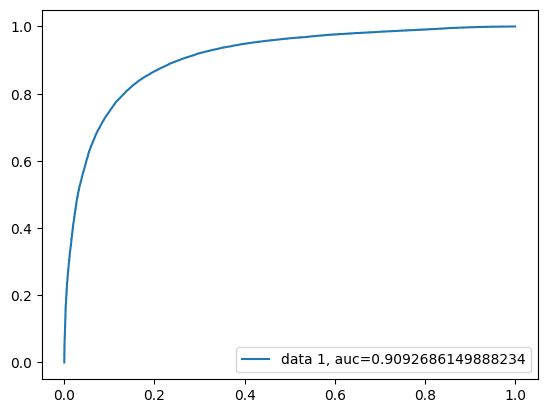

In [64]:
#plot AUC for external test set
fpr, tpr, thresholds = metrics.roc_curve(labels_test, pred)
# metrics.auc(fpr, tpr)
auc = metrics.roc_auc_score(labels_test, pred)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [65]:
from sklearn.metrics import precision_recall_curve, auc
# Compute precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(labels_test, pred)

# Calculate AUPR
aupr = auc(recall, precision)
print(aupr)

0.9082954461668751


In [66]:
#use 0.5 as a cut off for predictions of model
for i in range(len(pred)):
  if (pred[i]>0.5):
    pred[i]=1
  else:
    pred[i]=0

In [67]:
#calculate the MCC of model
metrics.matthews_corrcoef(labels_test, pred)

np.float64(0.6702332519536219)

In [68]:
metrics.accuracy_score(labels_test, pred)

0.8348144225677562

In [69]:
#classification report for external test set with esm
print(classification_report(labels_test, pred, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.85      0.81      0.83     51881
           1       0.82      0.86      0.84     51984

    accuracy                           0.83    103865
   macro avg       0.84      0.83      0.83    103865
weighted avg       0.84      0.83      0.83    103865



In [70]:
tn, fp, fn, tp = confusion_matrix(labels_test, pred).ravel()

# Calculate Sensitivity (Recall) and Specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")

Sensitivity (Recall): 0.8564
Specificity: 0.8131


In [60]:
print(tn, fp, fn, tp)

45592 6289 8000 43984


In [30]:
#external / HLA
import numpy as np
import seaborn as sns
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Load peptide embeddings for test set
with open(r"C:\Users\asus\Desktop\revised things\tests_ESM320_embeddings.pkl", "rb") as f:
    peptide_embeddings_test = pickle.load(f)

# Load test dataset
test = pd.read_csv(r"C:\Users\asus\Desktop\revised things\TransPHLA-AOMP-master\TransPHLA-AOMP-master\Dataset\external_set.csv")

# Preprocess HLA names (remove "*")
test["HLA"] = test["HLA"].str.replace("*", "", regex=False)

# Extract unique HLAs for evaluation
new_hla_list = test["HLA"].unique()

# Iterate over each unique HLA in the test set
for HLA in new_hla_list:
    print(f"\nEvaluating HLA: {HLA}")
    
    # Subset test data for the current HLA
    test_subset = test[test["HLA"] == HLA]

    # Get peptide and HLA embeddings
    peptides_test = np.array([peptide_embeddings_test[p] for p in test_subset["peptide"]])
    hlas_test = np.array([hla_df.loc[h].values for h in test_subset["HLA"]])
    labels_test = test_subset["label"].values

    # Reshape for model input
    peptides_test = peptides_test.reshape(-1, 320)
    hlas_test = hlas_test.reshape(-1, 180)

    # Model prediction
    pred_probs = siamese_net.predict([peptides_test, hlas_test])
    auc = roc_auc_score(labels_test, pred_probs)
    print(f"AUC: {auc:.4f}")

    # Convert probabilities to binary predictions (Threshold = 0.5)
    pred_labels = (pred_probs > 0.5).astype(int)

    # Compute confusion matrix
    cm = confusion_matrix(labels_test, pred_labels)
    print("Confusion Matrix:\n", cm)

    try:
        sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
        specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
        print(f"Sensitivity: {sensitivity:.4f}")
        print(f"Specificity: {specificity:.4f}")

        # Classification report
        clf_report = classification_report(labels_test, pred_labels, target_names=["0", "1"], output_dict=True)
        print(classification_report(labels_test, pred_labels, target_names=["0", "1"]))

        # Plot classification report heatmap
        # sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, cmap="Blues")
        # plt.title(f"Classification Report for {HLA}")
        # plt.show()

    except Exception as e:
        print(f"Skipping HLA {HLA} due to error: {e}")
        continue



Evaluating HLA: HLA-A01:01
271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
AUC: 0.9551
Confusion Matrix:
 [[4060  257]
 [ 731 3596]]
Sensitivity: 0.9405
Specificity: 0.8311
              precision    recall  f1-score   support

           0       0.85      0.94      0.89      4317
           1       0.93      0.83      0.88      4327

    accuracy                           0.89      8644
   macro avg       0.89      0.89      0.89      8644
weighted avg       0.89      0.89      0.89      8644


Evaluating HLA: HLA-A02:01
280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
AUC: 0.9173
Confusion Matrix:
 [[3979  479]
 [1005 3474]]
Sensitivity: 0.8926
Specificity: 0.7756
              precision    recall  f1-score   support

           0       0.80      0.89      0.84      4458
           1       0.88      0.78      0.82      4479

    accuracy                           0.83      8937
   macro avg       0.84      0.83      0.83      8937
weighted avg       0.84      0.83      0.83      8937


Evaluating 

In [31]:
# external / length
import numpy as np
import seaborn as sns
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Load peptide embeddings for test set
with open(r"C:\Users\asus\Desktop\revised things\tests_ESM320_embeddings.pkl", "rb") as f:
    peptide_embeddings_test = pickle.load(f)

# Load test dataset
test = pd.read_csv(r"C:\Users\asus\Desktop\revised things\TransPHLA-AOMP-master\TransPHLA-AOMP-master\Dataset\external_set.csv")

# Preprocess HLA names (remove "*")
test["HLA"] = test["HLA"].str.replace("*", "", regex=False)

# Extract unique HLAs for evaluation
length_list = test["length"].unique()

# Iterate over each unique HLA in the test set
for length in length_list:
    print(f"\nEvaluating length: {length}")
    
    # Subset test data for the current HLA
    test_subset = test[test["length"] == length]

    # Get peptide and HLA embeddings
    peptides_test = np.array([peptide_embeddings_test[p] for p in test_subset["peptide"]])
    hlas_test = np.array([hla_df.loc[h].values for h in test_subset["HLA"]])
    labels_test = test_subset["label"].values

    # Reshape for model input
    peptides_test = peptides_test.reshape(-1, 320)
    hlas_test = hlas_test.reshape(-1, 180)

    # Model prediction
    pred_probs = siamese_net.predict([peptides_test, hlas_test])
    auc = roc_auc_score(labels_test, pred_probs)
    print(f"AUC: {auc:.4f}")

    # Convert probabilities to binary predictions (Threshold = 0.5)
    pred_labels = (pred_probs > 0.5).astype(int)

    # Compute confusion matrix
    cm = confusion_matrix(labels_test, pred_labels)
    print("Confusion Matrix:\n", cm)

    try:
        sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
        specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
        print(f"Sensitivity: {sensitivity:.4f}")
        print(f"Specificity: {specificity:.4f}")

        # Classification report
        clf_report = classification_report(labels_test, pred_labels, target_names=["0", "1"], output_dict=True)
        print(classification_report(labels_test, pred_labels, target_names=["0", "1"]))

        # Plot classification report heatmap
        # sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, cmap="Blues")
        # plt.title(f"Classification Report for {HLA}")
        # plt.show()

    except Exception as e:
        print(f"Skipping HLA {HLA} due to error: {e}")
        continue



Evaluating length: 8
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
AUC: 0.9618
Confusion Matrix:
 [[14560  1551]
 [ 1642 14478]]
Sensitivity: 0.9037
Specificity: 0.8981
              precision    recall  f1-score   support

           0       0.90      0.90      0.90     16111
           1       0.90      0.90      0.90     16120

    accuracy                           0.90     32231
   macro avg       0.90      0.90      0.90     32231
weighted avg       0.90      0.90      0.90     32231


Evaluating length: 9
1448/1448 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
AUC: 0.9478
Confusion Matrix:
 [[20798  2327]
 [ 3541 19665]]
Sensitivity: 0.8994
Specificity: 0.8474
              precision    recall  f1-score   support

           0       0.85      0.90      0.88     23125
           1       0.89      0.85      0.87     23206

    accuracy                           0.87     46331
   macro avg       0.87      0.87      0.87     46331
weighted avg       0.87      0.87      0.87     46331


Evaluating 

In [50]:
# independent/length
import numpy as np
import seaborn as sns
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Load peptide embeddings for test set
with open(r"C:\Users\asus\Desktop\revised things\tests_ESM320_embeddings.pkl", "rb") as f:
    peptide_embeddings_test = pickle.load(f)

# Load test dataset
test = pd.read_csv(r"C:\Users\asus\Desktop\revised things\TransPHLA-AOMP-master\TransPHLA-AOMP-master\Dataset\independent_set.csv")

# Preprocess HLA names (remove "*")
test["HLA"] = test["HLA"].str.replace("*", "", regex=False)

# Extract unique HLAs for evaluation
length_list = test["length"].unique()

# Iterate over each unique HLA in the test set
for length in length_list:
    print(f"\nEvaluating length: {length}")
    
    # Subset test data for the current HLA
    test_subset = test[test["length"] == length]

    # Get peptide and HLA embeddings
    peptides_test = np.array([peptide_embeddings_test[p] for p in test_subset["peptide"]])
    hlas_test = np.array([hla_df.loc[h].values for h in test_subset["HLA"]])
    labels_test = test_subset["label"].values

    # Reshape for model input
    peptides_test = peptides_test.reshape(-1, 320)
    hlas_test = hlas_test.reshape(-1, 180)

    # Model prediction
    pred_probs = siamese_net.predict([peptides_test, hlas_test])
    auc = roc_auc_score(labels_test, pred_probs)
    print(f"AUC: {auc:.4f}")

    # Convert probabilities to binary predictions (Threshold = 0.5)
    pred_labels = (pred_probs > 0.5).astype(int)

    # Compute confusion matrix
    cm = confusion_matrix(labels_test, pred_labels)
    print("Confusion Matrix:\n", cm)

    try:
        sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
        specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
        print(f"Sensitivity: {sensitivity:.4f}")
        print(f"Specificity: {specificity:.4f}")

        # Classification report
        clf_report = classification_report(labels_test, pred_labels, target_names=["0", "1"], output_dict=True)
        print(classification_report(labels_test, pred_labels, target_names=["0", "1"]))

        # Plot classification report heatmap
        # sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, cmap="Blues")
        # plt.title(f"Classification Report for {HLA}")
        # plt.show()

    except Exception as e:
        print(f"Skipping HLA {HLA} due to error: {e}")
        continue



Evaluating length: 8
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
AUC: 0.9751
Confusion Matrix:
 [[3414  339]
 [ 231 3524]]
Sensitivity: 0.9097
Specificity: 0.9385
              precision    recall  f1-score   support

           0       0.94      0.91      0.92      3753
           1       0.91      0.94      0.93      3755

    accuracy                           0.92      7508
   macro avg       0.92      0.92      0.92      7508
weighted avg       0.92      0.92      0.92      7508


Evaluating length: 9
3612/3612 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
AUC: 0.9777
Confusion Matrix:
 [[52051  5595]
 [ 2715 55203]]
Sensitivity: 0.9029
Specificity: 0.9531
              precision    recall  f1-score   support

           0       0.95      0.90      0.93     57646
           1       0.91      0.95      0.93     57918

    accuracy                           0.93    115564
   macro avg       0.93      0.93      0.93    115564
weighted avg       0.93      0.93      0.93    115564


Evaluating length

# functions

## HLA IC feature

In [32]:
def IC_feature():
    import warnings
    warnings.filterwarnings('ignore')
    
    alldata0 = pd.read_csv(r"C:\Users\asus\Desktop\revised things\TransPHLA-AOMP-master\TransPHLA-AOMP-master\Dataset\train_data_fold0.csv")
    alldata1 = pd.read_csv(r"C:\Users\asus\Desktop\revised things\TransPHLA-AOMP-master\TransPHLA-AOMP-master\Dataset\train_data_fold1.csv")
    alldata2 = pd.read_csv(r"C:\Users\asus\Desktop\revised things\TransPHLA-AOMP-master\TransPHLA-AOMP-master\Dataset\train_data_fold2.csv")
    alldata3 = pd.read_csv(r"C:\Users\asus\Desktop\revised things\TransPHLA-AOMP-master\TransPHLA-AOMP-master\Dataset\train_data_fold3.csv")
    alldata4 = pd.read_csv(r"C:\Users\asus\Desktop\revised things\TransPHLA-AOMP-master\TransPHLA-AOMP-master\Dataset\train_data_fold4.csv")
    # Correct concatenation syntax:
    alldata = pd.concat([alldata0, alldata1, alldata2, alldata3, alldata4])
    alldata['HLA'] = alldata['HLA'].str.replace('*', '')
    # data_train, data_val = train_test_split(alldata, test_size=0.2, random_state=42)
    # data_train.to_csv(r"C:\Users\asus\Desktop\master article\Maryam\esm320\train_data.csv")
    # data_val.to_csv(r"C:\Users\asus\Desktop\master article\Maryam\esm320\validation_data.csv")
    
    
    HLA_list = alldata['HLA'].unique()
    test_keys = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
    test_values = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
    res = {}
    for key in test_keys:
        for value in test_values:
            res[key] = value
            test_values.remove(value)
            break
    column = [0]*181
    column[0] = 'HLA'
    for i in range(1, 181):
      column[i] = (str(i+319))
    
    
    antropy_data = pd.DataFrame(columns = column)
    for HLA in tqdm(HLA_list):
      data = alldata[alldata.HLA == HLA]
      data_0 = data[data.label == 0]
      data_1 = data[data.label == 1]

      data_0 = data_0[data_0.length == 9]
      data_1 = data_1[data_1.length == 9]

      #character profile
      arr0 = [[0 for _ in range(9)] for _ in range(len(data_0))]
      j=0
      for _, row in data_0.iterrows():
        for i in range(9):
          arr0[j][i] = row['peptide'][i]
        j=j+1

      arr1 = [[0 for _ in range(9)] for _ in range(len(data_1))]
      j=0
      for _, row in data_1.iterrows():
        for i in range(9):
          arr1[j][i] = row['peptide'][i]
        j=j+1

      arr_0 = [[pow(10, -10) for _ in range(9)] for _ in range(20)]
      arr_1 = [[pow(10, -10) for _ in range(9)] for _ in range(20)]

      #probability profile
      for i in range(len(arr0)):
        for j in range(9):
          char = res[arr0[i][j]]
          arr_0[char][j] = arr_0[char][j] + (1/len(data_0))

      for i in range(len(arr1)):
        for j in range(9):
          char = res[arr1[i][j]]
          arr_1[char][j] = arr_1[char][j] + (1/len(data_1))

      #antropy matrix
      antropy = [[0 for _ in range(9)] for _ in range(20)]

      for i in range(20):
        for j in range(9):
          antropy[i][j] = arr_1[i][j]*(math.log((arr_1[i][j]/arr_0[i][j]),20))
      
      flattened_array = [element for column in zip(*antropy) for element in column]
  
      # flattened_array = [element for row in antropy for element in row]
      feature_antropy = [0]*181
      feature_antropy[0] = HLA
      feature_antropy[1:] = flattened_array
      new_df = pd.DataFrame(np.array(feature_antropy).reshape(1, -1), columns=column)
      antropy_data = pd.concat([antropy_data, new_df], ignore_index=True)
    
    
    antropy_data.to_csv(r"C:\Users\asus\Desktop\final_entropy_column.csv")

In [33]:
IC_feature()

100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [02:59<00:00,  1.60s/it]


In [77]:
!pip install biopython
import warnings
warnings.filterwarnings('ignore')
from Bio import pairwise2
from Bio.Align import substitution_matrices

def calculate_similarity(seq1, seq2, matrix):
    alignments = pairwise2.align.globalds(seq1, seq2, matrix, -10, -0.5)
    score = alignments[0][2]
    max_score = min(len(seq1), len(seq2)) * matrix[('A', 'A')]
    return score / max_score

def calculate_percentage_similarities(sequences):
    matrix = substitution_matrices.load("BLOSUM62")
    n = len(sequences)
    similarity_matrix = [[0] * n for _ in range(n)]

    for i in range(n):
        for j in range(n):
            if i != j:
                similarity_matrix[i][j] = calculate_similarity(sequences[i], sequences[j], matrix)

    percentages = []
    for i in range(n):
        total_similarity = sum(similarity_matrix[i])
        percentages.append([similarity_matrix[i][j] / total_similarity for j in range(n)])

    return percentages

# Example usage
header_hlaESM = [0]*180
for i in range(1, 181):
  header_hlaESM[i-1] = (str(i+319))

new_column = [0]*181
new_column[1:181] = header_hlaESM
new_column[0] = 'HLA'
antropy = pd.read_csv(r'C:\Users\asus\Desktop\master article\Maryam\esm320\final_entropy.csv', names = new_column, header=0)
unique_HLA = pd.read_csv(r'C:\Users\asus\Desktop\master article\Maryam\esm320\unique_HLA.csv')
antropy = pd.merge(antropy, unique_HLA, on=['HLA'])

sequences = antropy['HLA_sequence'].tolist()
percentages = calculate_percentage_similarities(sequences)
temp = antropy.copy()
antropy_data = pd.DataFrame(columns = new_column)
for i in tqdm(range(len(sequences))):
    r=0
    new_feature=[0]*181
    new_feature[0] = sequences[i]
    for j in range(320,500):
        temp[str(j)] = antropy[str(j)]*percentages[i]
        for z in range(len(sequences)):
            try:
                new_feature[j-319] = new_feature[j-319]+(float(temp[temp.HLA_sequence==sequences[z]][str(j)])/(len(sequences)-1))
            except:
                if r==0:
                    new_feature[j-319] = new_feature[j-319]+(float((temp[temp.HLA_sequence==sequences[z]][str(j)]).tolist()[0])/(len(sequences)-1))
                    r=1
                else:
                    new_feature[j-319] = new_feature[j-319]+(float((temp[temp.HLA_sequence==sequences[z]][str(j)]).tolist()[1])/(len(sequences)-1))
                    

    new_df = pd.DataFrame(np.array(new_feature).reshape(1, -1), columns=new_column)
    antropy_data = antropy_data.append(new_df, ignore_index=True)
    
antropy_data['HLA']=antropy['HLA']
antropy_data.to_csv(r"C:\Users\asus\Desktop\Maryam\esm320\final_entropy_removed_HLA.csv")

    # for i, seq_percentages in enumerate(percentages):
#     print(f"Sequence {i+1} similarities: {seq_percentages}")

100%|██████████| 112/112 [07:41<00:00,  4.12s/it]


In [ ]:
!pip install biopython
import warnings
warnings.filterwarnings('ignore')
from Bio import pairwise2
from Bio.Align import substitution_matrices

def calculate_similarity(seq1, seq2, matrix):
    alignments = pairwise2.align.globalds(seq1, seq2, matrix, -10, -0.5)
    score = alignments[0][2]
    max_score = min(len(seq1), len(seq2)) * matrix[('A', 'A')]
    return score / max_score

def calculate_percentage_similarities(sequences):
    matrix = substitution_matrices.load("BLOSUM62")
    n = len(sequences)
    similarity_matrix = [[0] * n for _ in range(n)]

    for i in range(n):
        for j in range(n):
            if i != j:
                similarity_matrix[i][j] = calculate_similarity(sequences[i], sequences[j], matrix)

    percentages = []
    for i in range(n):
        total_similarity = sum(similarity_matrix[i])
        percentages.append([similarity_matrix[i][j] / total_similarity for j in range(n)])

    return percentages

header_hlaESM = [0]*180
for i in range(1, 181):
  header_hlaESM[i-1] = (str(i+319))

new_column = [0]*181
new_column[1:181] = header_hlaESM
new_column[0] = 'HLA'
antropy = pd.read_csv(r'C:\Users\asus\Desktop\master article\Maryam\esm320\final_entropy.csv', names = new_column, header=0)

sequences = antropy['HLA_sequence'].tolist() ## should added a newly HLA sequence to this list
percentages = calculate_percentage_similarities(sequences)
temp = antropy.copy()
antropy_data = pd.DataFrame(columns = new_column)

## and just calculate new_feature just for our new HLA and returne this feature for new HLA
for i in tqdm(range(len(sequences))):
    r=0
    new_feature=[0]*181
    new_feature[0] = sequences[i]
    for j in range(320,500):
        temp[str(j)] = antropy[str(j)]*percentages[i]
        for z in range(len(sequences)):
            try:
                new_feature[j-319] = new_feature[j-319]+(float(temp[temp.HLA_sequence==sequences[z]][str(j)])/(len(sequences)-1))
            except:
                if r==0:
                    new_feature[j-319] = new_feature[j-319]+(float((temp[temp.HLA_sequence==sequences[z]][str(j)]).tolist()[0])/(len(sequences)-1))
                    r=1
                else:
                    new_feature[j-319] = new_feature[j-319]+(float((temp[temp.HLA_sequence==sequences[z]][str(j)]).tolist()[1])/(len(sequences)-1))
                    

    new_df = pd.DataFrame(np.array(new_feature).reshape(1, -1), columns=new_column)
    antropy_data = antropy_data.append(new_df, ignore_index=True)
    
antropy_data['HLA']=antropy['HLA']
antropy_data.to_csv(r"C:\Users\asus\Desktop\Maryam\esm320\final_entropy_removed_HLA.csv")

## ESM embedding

In [2]:
pip install fair-esm

Note: you may need to restart the kernel to use updated packages.
  Using cached fair_esm-2.0.0-py3-none-any.whl (93 kB)


You should consider upgrading via the 'c:\users\asus\venv\scripts\python.exe -m pip install --upgrade pip' command.


In [3]:
#ESM
# !pip install fair-esm #if it's needed
import esm # pip install fair-esm
import torch
import pandas as pd

def make_esm_representations(df,col, model):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    #df = pd.read_excel(input_file_name)
    peptides_list = df[col].tolist()
    esm_model, alphabet = model
    esm_model = esm_model.to(device)
    batch_converter = alphabet.get_batch_converter()

    peptides_list = [("", peptides_list[i]) for i in range(len(peptides_list))]
    batch_labels, batch_strs, batch_tokens = batch_converter(peptides_list)
    batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

    # Extract per-residue representations (on CPU or CUDA)
    results = esm_model(batch_tokens.to(device), repr_layers=[6], return_contacts=True)
    token_representations = results["representations"][6]

    # Generate per-sequence representations via averaging
    sequence_representations = []
    for i, tokens_len in enumerate(batch_lens):
        sequence_representations.append(token_representations[i, 1 : tokens_len - 1].mean(0))

    sequence_representations = torch.stack(sequence_representations)
    df = pd.DataFrame(sequence_representations.cpu().detach().numpy())
    return df
    #df.to_excel(output_file_name, index=False)
    #print(f'{output_file_name} file made')

def pretrained_model(dim):
    assert dim in [5120,2560,1280,640,480,320]
    if dim==5120:
        return esm.pretrained.esm2_t48_15B_UR50D()
    elif dim==2560:
        return esm.pretrained.esm2_t36_3B_UR50D()
    elif dim==1280:
        return esm.pretrained.esm2_t33_650M_UR50D()
    elif dim==640:
        return esm.pretrained.esm2_t30_150M_UR50D()
    elif dim==480:
        return esm.pretrained.esm2_t12_35M_UR50D()
    elif dim==320:
        return esm.pretrained.esm2_t6_8M_UR50D()

In [16]:
# data = {
#     "HLA": ['HLA-A01:01', 'HLA-A02:01', 'HLA-A24:02', 'HLA-B08:01', 'HLA-B18:01'],
#     "peptide": ['KVYLRVRPLL', 'KVYLRVRPLL', 'KVYLRVRPLL', 'KVYLRVRPLL', 'KVYLRVRPLL']
# }
my_set = pd.read_csv(r'C:\Users\asus\Desktop\revised things\TransPHLA-AOMP-master\TransPHLA-AOMP-master\Dataset\merged_neoantigen_data.csv')
# my_test = pd.DataFrame(data)
my_set['peptide'] = my_set['peptide'].str.upper()

In [17]:
#sample:
feature = make_esm_representations(my_set, 'peptide', model=pretrained_model(320))